## Imbalance Classification
#### Approach :

#### Steps Involved : 
#### Step-1. Data Explore :
Data explore and removing unnecessary features

(1.DataExplore.ipynb)
#### Step-2. Data Processing : 
Train & Validation data split, Categorical variables encoding & imputation, Continuous variables imputation
Final Train & Validation datasets created.

(2.DataProcessing.ipynb)
#### Step-3. First Set of Classifier Model : 
First set of XGBoost model, Hyper-parameter tuning, Decile plots, Feature Importance, Calibration plots

(3a.i.XGBClass_Grid_LogLoss_PropensityModel.ipynb)
#### Step-4. Feature Elimination : 
Feature Elimination checks

(3a_ii_Feature_Elimination_XGB.ipynb)
#### Step-5. Imbalanced dataset variations
Creating multiple variations with the Oversampling & Undersampling techniques

(3a.iii.XGBClass_Imbalance_1.ipynb)

(3a.iii.XGBClass_Imbalance_2.ipynb)

(3a.iii.XGBClass_Imbalance_3.ipynb)
#### Step-6. Probability cutoff & Model checks
(3a.iv.ProbabCutOff_beforeImbalance.ipynb)

(3a.iv.ProbabCutOff.ipynb)
#### Step-7. Scoring on Valiation data using the Probability Threshold calculated in Step-6 to further shortlist best model
(4_Scoring_Approach.ipynb)

* Classifier Model has been built using the XGBoost library, along with Grid Search and 3 different sets of models are prepared, which are further compared on the basis of LogLoss value on validation dataset. On Checking the Lift, LogLoss, AUC metrics, & feature elimination, another set of models have been built, and the best model is selected on the basis of Lift provided in first decile, assuming no leakage introduced.

* To ensure the generalization being introduced by the model, the Train dataset has been split into 2 parts (80% and 20%) :
* a) 1st model is trained on the 80% dataset and validated on 20% dataset 
* b) The hyper-parameters tuning has been done and results are checked on both train and validation dataset
* c) Few variations have been tried to check on the imbalance dataset 
* d) Depending upon the best possible probability threshold, a CutOff has been found for each of the dataset
* e) Best model from above step is selected by checking the performances on the validation dataset. 
* The final model from the above step can be used to score on the Test dataset, or the validation dataset can be included to train a better robust model

* All the entries from the Train Dataset are taken for both classes 1 and 0 (-1 has been replaced with 0)


### Final Model Name :  xgb_sigmoid.pkl

In [1]:
# Change values in cells with '+++++++ INPUT : ' as per need! Not valid for all cells, Paths are MUST!
import platform
print(platform.python_version())

3.7.4


In [2]:
#!pip install xgboost

In [3]:
import xgboost as xgb
import numpy as np
import pandas as pd
import random
import os

import sklearn as sk
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.calibration import calibration_curve
import joblib
from xgboost.sklearn import XGBClassifier

#import plotly.plotly as py
#from plotly.offline import download_plotlyjs
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# from spark_learn import GridSearchCV
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Import Helper file with the roc-lift-calibration plots
import roc_lift_calibration_feat_imp as rlcfi
#reload(rlcfi)

%load_ext autoreload
%autoreload 2

In [4]:
# ++++++++ INPUT : Change These variables, as per your need +++++++
project_path = '/Users/palashgoyal1/Downloads/CV/Case_Studies/Sigmoid/'
model_path=os.path.join(project_path, 'model/1/')
grid_files_path=os.path.join(project_path,'model/1/gs_files/cc_auc_')
home_path=model_path
train_pred_file_name = 'cc_approach_ClassPred.csv'


# Make sure the train_file has columns with names (Target, ID_Col), and test_file has columns with name (ID_Col)
train_file = os.path.join(project_path,'data/2/training_data.csv')
test_file=os.path.join(project_path,'data/2/validation_data.csv')

In [5]:
# ++++++++ INPUT : Change These variables, as per your need +++++++
# Models Name:  (Small error with naming convention has been made here!)
model1 = 'xgb1_cc_auc.pkl'
model2 = 'xgb2_cc_auc.pkl'
model3 = 'xgb3_cc_auc.pkl'

In [6]:
# modelfit(..) and Grid Search Parameters
# Introduce 'switch' statements here, and then select these variables accordingly
modelfit_metric='logloss'
scoring_parameter='neg_log_loss'

In [7]:
scoring_objective='binary:logistic'
scoring_seed=45

In [8]:
train_final = pd.read_csv(train_file, sep=',')

In [9]:
train_final.head()

,Var192_0,Var192_1,Var192_2,Var197_0,Var197_1,Var197_2,Var199_0,Var199_1,Var199_2,Var202_0,...,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,labels
0,0.0,5.0,3.0,1.0,0.0,1.0,1.0,2.0,-1.0,-1.0,...,345.000000,0.00000,9.000000,2.419200e+06,1.043516e+07,44.000000,0.000000e+00,0.000000,0.000000,0
1,3.0,1.0,0.0,-1.0,-1.0,-2.0,-3.0,1.0,0.0,1.0,...,995.000000,0.00000,18.000000,0.000000e+00,6.395240e+05,20.000000,0.000000e+00,0.000000,0.000000,0
2,1.0,2.0,1.0,0.0,0.0,-2.0,-1.0,0.0,-1.0,0.0,...,0.000000,0.00000,0.000000,0.000000e+00,1.071364e+07,0.000000,0.000000e+00,0.000000,0.000000,0
3,0.0,1.0,-1.0,-2.0,2.0,0.0,0.0,-1.0,1.0,-1.0,...,3195.000000,0.00000,0.000000,0.000000e+00,9.853240e+06,6.000000,2.073600e+06,0.000000,0.000000,1
4,-2.0,1.0,-1.0,0.0,0.0,0.0,-2.0,0.0,-1.0,-1.0,...,1382.248228,0.06053,11.739064,2.960004e+05,6.173408e+06,38.705797,4.819043e+05,0.006614,0.616308,0


In [10]:
train_final.columns

Index(['Var192_0', 'Var192_1', 'Var192_2', 'Var197_0', 'Var197_1', 'Var197_2',
       'Var199_0', 'Var199_1', 'Var199_2', 'Var202_0', 'Var202_1', 'Var202_2',
       'Var206_0', 'Var206_1', 'Var206_2', 'Var217_0', 'Var217_1', 'Var217_2',
       'Var219_0', 'Var219_1', 'Var219_2', 'Var223_0', 'Var223_1', 'Var223_2',
       'Var205_0', 'Var205_1', 'Var205_2', 'Var218_0', 'Var218_1', 'Var203_0',
       'Var203_1', 'Var208_0', 'Var208_1', 'Var6', 'Var7', 'Var13', 'Var21',
       'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var65',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134',
       'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163',
       'Var173', 'Var181', 'labels'],
      dtype='object')

In [11]:
val_tar = train_final["labels"]
train_final.drop(['labels'], axis=1, inplace=True)

In [12]:
train_final.columns

Index(['Var192_0', 'Var192_1', 'Var192_2', 'Var197_0', 'Var197_1', 'Var197_2',
       'Var199_0', 'Var199_1', 'Var199_2', 'Var202_0', 'Var202_1', 'Var202_2',
       'Var206_0', 'Var206_1', 'Var206_2', 'Var217_0', 'Var217_1', 'Var217_2',
       'Var219_0', 'Var219_1', 'Var219_2', 'Var223_0', 'Var223_1', 'Var223_2',
       'Var205_0', 'Var205_1', 'Var205_2', 'Var218_0', 'Var218_1', 'Var203_0',
       'Var203_1', 'Var208_0', 'Var208_1', 'Var6', 'Var7', 'Var13', 'Var21',
       'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var65',
       'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109',
       'Var112', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134',
       'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163',
       'Var173', 'Var181'],
      dtype='object')

In [13]:
print(train_final.shape)

(40000, 68)


In [14]:
val_tar = pd.DataFrame(pd.Series(val_tar))

In [15]:
from copy import deepcopy
vt = deepcopy(val_tar)

In [16]:
train_final.reset_index(drop=True, inplace=True)
val_tar.reset_index(drop=True, inplace=True)

In [17]:
train_final = train_final.round(2)

In [19]:
for col_ in train_final.columns : 
    print(col_, ' : ', train_final[col_].unique())

Var192_0  :  [ 0.  3.  1. -2.  2. -1. -5. -3. -4.  5. -6.  4.]
Var192_1  :  [ 5.  1.  2. -1. -2.  3.  0.  4.]
Var192_2  :  [ 3.  0.  1. -1.  2. -3. -2.  4. -4.]
Var197_0  :  [ 1. -1.  0. -2.  3.  2. -5. -3.]
Var197_1  :  [ 0. -1.  2.  1. -3. -2.  3.]
Var197_2  :  [ 1. -2.  0.  2. -1.  3. -3.]
Var199_0  :  [ 1. -3. -1.  0. -2.  3.  2.  4. -4. -5. -6. -7.  5. -9.]
Var199_1  :  [ 2.  1.  0. -1. -2.  4.  3. -3.  5.  6. -4. -7.  7. -5.  8.]
Var199_2  :  [-1.  0.  1. -2.  2. -4. -3.  3. -5.  5.  4.  6. -6. -7.  7. -8.]
Var202_0  :  [-1.  1.  0. -2.  2. -3.  3. -4.  4. -5.]
Var202_1  :  [ 0. -3.  1. -1. -2.  2.  3.  4.]
Var202_2  :  [-1.  1.  0. -2.  2. -3.  3. -4.  4.]
Var206_0  :  [-1.  1. -5. -2.  0.]
Var206_1  :  [ 0.  1.  2. -1.]
Var206_2  :  [-1.  1.  0. -2.  3.]
Var217_0  :  [-1.  1.  0. -2.  2. -5. -3.  3.  4. -4.]
Var217_1  :  [ 1.  0.  2. -1. -3. -2.  3.  4. -4.]
Var217_2  :  [ 0. -1.  1.  3. -2.  2. -4. -3.  4.]
Var219_0  :  [ 0. -1. -3. -5. -2.  1.]
Var219_1  :  [ 0.  3.  1.  2.  

In [19]:
# Separate into Train and Validation
random.seed(45)
X_train, X_val, Y_train, Y_val = train_test_split(train_final, val_tar, 
                                                                           test_size = 0.2, random_state = 5)

In [30]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[['labels']].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=[ modelfit_metric ], early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric=modelfit_metric)     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("ROC AUC Score (Train): %f" % roc_auc_score(np.ravel(Y_train), dtrain_predprob))
    print("Log Loss (Train): %f " % log_loss(np.ravel(Y_train), dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(12,12))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [31]:
# temporary variables
# Initial set of parameters are taken on the basis of previous experience
ini_max_depth = 3
ini_min_child_weight= 5
ini_gamma= 0.2
ini_colsample_bytree=0.7
ini_subsample= 0.9
ini_reg_alpha =1
ini_reg_lambda =5
ini_max_delta_step= 1
ini_scale_pos_weight=1
ini_learning_rate = 0.05
ini_n_estimators = 700

In [32]:
grid_1 =  {'max_depth': ini_max_depth, 'min_child_weight': ini_min_child_weight, 'gamma':ini_gamma, 
           'colsample_bytree':ini_colsample_bytree, 'subsample':ini_subsample, 'reg_alpha' : ini_reg_alpha, 
           'reg_lambda' : ini_reg_lambda, 'max_delta_step' : ini_max_delta_step, 
           'scale_pos_weight': ini_scale_pos_weight, 'learning_rate' : ini_learning_rate, 
           'n_estimators':ini_n_estimators, 'objective': scoring_objective,  'seed':scoring_seed}

In [33]:
# xgboost classifier : Using the best params by experience
xgb1 = XGBClassifier(**grid_1)

In [34]:
#list(train_final.dtypes)

/Users/palashgoyal1/Setups/anaconda3/envs/foodai/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


ROC AUC Score (Train): 0.712489
Log Loss (Train): 0.240959 


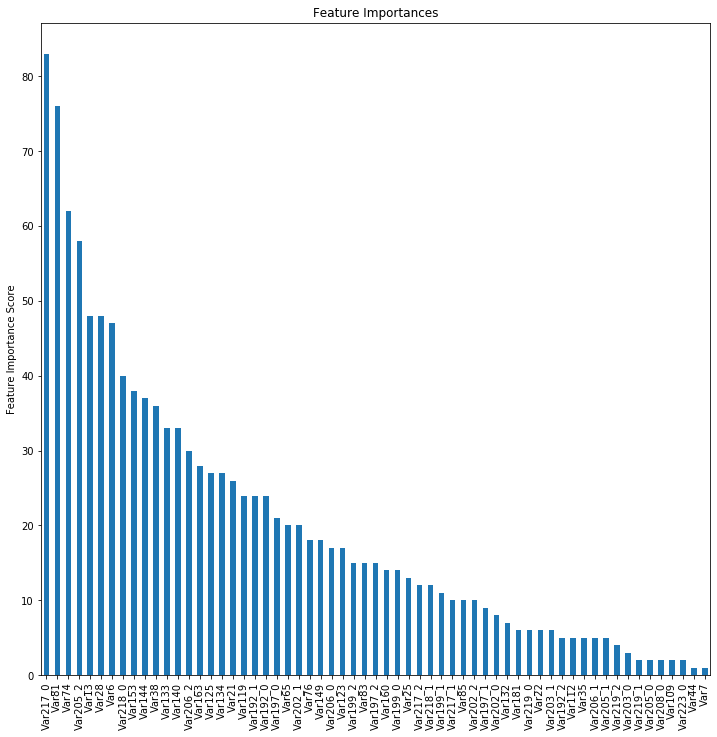

In [35]:
predictors  = list(X_train.columns)
modelfit(xgb1, X_train, predictors)

In [40]:
# Train log_loss
y_predS = xgb1.predict_proba(X_train)
metric_1 = log_loss(Y_train, y_predS[:,1])
print(metric_1)

0.24095932959954372


In [56]:
# Save the model
joblib.dump(xgb1, model_path+model1)

['/Users/palashgoyal1/Downloads/CV/Case_Studies/Sigmoid/model/1/xgb1_cc_auc.pkl']

In [59]:
# Cross validation AUC & log_loss
cv_score = cross_val_score(xgb1, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score.mean()))
print('std auc: ' + str(cv_score.std()))
cv_score1 = cross_val_score(xgb1, X_train, np.ravel(Y_train), cv = 5, scoring ='neg_log_loss')
print('mean log_loss: ' + str(cv_score1.mean()))
print('std log_loss: ' + str(cv_score1.std()))

mean auc: 0.6532766196169053
std auc: 0.0026451744295444275
mean log_loss: -0.24907325457158733
std log_loss: 0.0010474625009880174


In [60]:
# Validation AUC
val_pred = xgb1.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred[:,1])))
print('Validation log_loss: ' + str(log_loss(Y_val, val_pred[:,1])))

Validation AUC: 0.6289229016949154
Validation log_loss: 0.26509480861166956


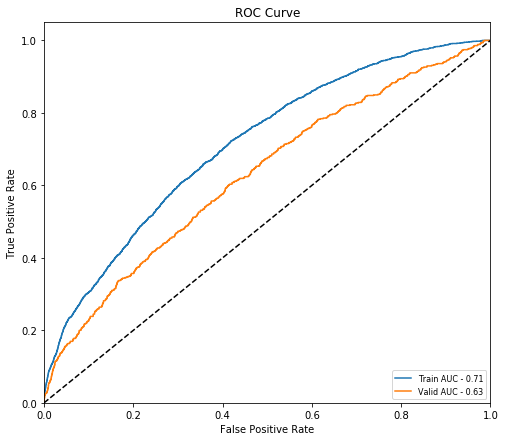

In [61]:
# Make ROC curve for train and validation
fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [68]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[ 1,5],
   'min_child_weight':[1,5]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective, seed=scoring_seed), 
param_grid = param_test1, scoring=scoring_parameter,n_jobs=-1, cv=5)

gsearch1.fit(X_train,np.ravel(Y_train))

pd.Series(gsearch1.cv_results_).to_csv(grid_files_path+'gs_search1.csv')
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


({'mean_fit_time': array([ 26.29950795,  26.44069319, 105.48376298,  78.25100913]),
  'std_fit_time': array([ 0.03114164,  0.2875565 ,  0.27493178, 21.91258563]),
  'mean_score_time': array([0.07519298, 0.08126631, 0.18062301, 0.11831703]),
  'std_score_time': array([0.00147476, 0.00543703, 0.00876559, 0.04596412]),
  'param_max_depth': masked_array(data=[1, 1, 5, 5],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 5, 1, 5],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 1, 'min_child_weight': 1},
   {'max_depth': 1, 'min_child_weight': 5},
   {'max_depth': 5, 'min_child_weight': 1},
   {'max_depth': 5, 'min_child_weight': 5}],
  'split0_test_score': array([-0.24946591, -0.24950082, -0.25289486, -0.25309488]),
  'split1_test_score': array([-0.25026491, -0.25031118, -0.25606331, -0.256246  ]),
  'spl

In [72]:
# Best till here : Order is on the basis of the params given!
ini_max_depth = list(gsearch1.best_params_.values())[0]
ini_min_child_weight = list(gsearch1.best_params_.values())[1]

In [81]:
# Tune tree pruning parameters: gamma
param_test2 = {
   'gamma':[i/10.0 for i in range(0,5)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective,  seed=scoring_seed), 
param_grid = param_test2, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch2.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch2.cv_results_).to_csv(grid_files_path+'gs_search2.csv')
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([3.99926496, 4.21316562, 4.18885846, 4.16499557, 4.14994202]),
  'std_fit_time': array([0.26163203, 0.1938743 , 0.1182077 , 0.19706194, 0.12051689]),
  'mean_score_time': array([0.01695166, 0.01694303, 0.01742191, 0.01808605, 0.01654549]),
  'std_score_time': array([0.00115339, 0.00083002, 0.00242428, 0.00360056, 0.00080635]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([-0.25010008, -0.25010008, -0.25010008, -0.25009851, -0.2500818 ]),
  'split1_test_score': array([-0.25054313, -0.25054313, -0.25054313, -0.25054313, -0.25054313]),
  'split2_test_score': array([-0.25022369, -0.25022369, -0.25020198, -0.25020114, -0.25020114]),
  'split3_test_score': array([-0.24918454, -0.24921485, -0.24921485, -0.2492

In [82]:
# Best till here :
ini_gamma = list(gsearch2.best_params_.values())[0]

In [78]:
# Tune tree pruning parameters: subsample, colsample_bytree
param_test3 = {
  'subsample':[0.7,0.9],
 'colsample_bytree':[0.5,0.9]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective, seed=scoring_seed), 
param_grid = param_test3, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch3.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch3.cv_results_).to_csv(grid_files_path+'gs_search3.csv')
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([3.58421969, 3.72393723, 5.0183671 , 5.2334178 ]),
  'std_fit_time': array([0.21714967, 0.21729101, 0.15098877, 0.07391876]),
  'mean_score_time': array([0.01632824, 0.01831055, 0.01721082, 0.01874423]),
  'std_score_time': array([0.00062974, 0.00251325, 0.00086425, 0.00280021]),
  'param_colsample_bytree': masked_array(data=[0.5, 0.5, 0.9, 0.9],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.7, 0.9, 0.7, 0.9],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'colsample_bytree': 0.5, 'subsample': 0.7},
   {'colsample_bytree': 0.5, 'subsample': 0.9},
   {'colsample_bytree': 0.9, 'subsample': 0.7},
   {'colsample_bytree': 0.9, 'subsample': 0.9}],
  'split0_test_score': array([-0.24951085, -0.24950309, -0.24962712, -0.24947917]),
  'split1_test_score': array([-0.25017002, -0.25028459, -0.25039367, -

In [79]:
# Best till here :
ini_subsample = list(gsearch3.best_params_.values())[0]
ini_colsample_bytree = list(gsearch3.best_params_.values())[1]

In [84]:
# Tune tree pruning parameters: reg_alpha
param_test4 = {
    'reg_alpha':[ 1e-5, 0, 0.1, 1, 10]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective, seed=scoring_seed), 
param_grid = param_test4, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch4.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch4.cv_results_).to_csv(grid_files_path+'gs_search4.csv')
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([4.01197014, 4.17082534, 4.46269779, 4.36749825, 4.29726815]),
  'std_fit_time': array([0.24697297, 0.30286503, 0.22776701, 0.07510754, 0.20296293]),
  'mean_score_time': array([0.01608543, 0.01767731, 0.01717119, 0.01880612, 0.01744366]),
  'std_score_time': array([0.00090426, 0.00329212, 0.000889  , 0.00264992, 0.00118773]),
  'param_reg_alpha': masked_array(data=[1e-05, 0, 0.1, 1, 10],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 10}],
  'split0_test_score': array([-0.25019249, -0.2501925 , -0.25016003, -0.2500818 , -0.24999125]),
  'split1_test_score': array([-0.25053101, -0.25053101, -0.25055308, -0.25054313, -0.25034386]),
  'split2_test_score': array([-0.25030835, -0.25030835, -0.25030719, -0.25020114, -0.25021881]),
  'split3_test_score': array([-0.24921727, -0.24921727, -0

In [85]:
# Best till here :
ini_reg_alpha= list(gsearch4.best_params_.values())[0]

In [86]:
# Tune tree pruning parameters: reg_lambda
param_test5 = {
  'reg_lambda':[0, 1, 5, 10]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective,  seed=scoring_seed), 
param_grid = param_test5, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch5.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch5.cv_results_).to_csv(grid_files_path+'gs_search5.csv')
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([4.03467536, 3.61005478, 3.79280796, 4.04367399]),
  'std_fit_time': array([0.23439209, 0.06974203, 0.17613822, 0.09090271]),
  'mean_score_time': array([0.01655798, 0.01460338, 0.01586566, 0.01696606]),
  'std_score_time': array([0.00109289, 0.00021441, 0.0007889 , 0.0006734 ]),
  'param_reg_lambda': masked_array(data=[0, 1, 5, 10],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 0},
   {'reg_lambda': 1},
   {'reg_lambda': 5},
   {'reg_lambda': 10}],
  'split0_test_score': array([-0.24989622, -0.24983165, -0.2500818 , -0.25030994]),
  'split1_test_score': array([-0.25070739, -0.250625  , -0.25054313, -0.2504936 ]),
  'split2_test_score': array([-0.25021396, -0.25009102, -0.25020114, -0.2504232 ]),
  'split3_test_score': array([-0.24878419, -0.2489678 , -0.24921485, -0.24932223]),
  'split4_test_score': array([-0.24996271, -0.25005346, -0.24994398, -0.24997152]),
  'mean_test_sc

In [87]:
# Best till here :
ini_reg_lambda= list(gsearch5.best_params_.values())[0]

In [88]:
# Tune tree pruning parameters: max_delta_step
param_test6 = {
  'max_delta_step':[0, 1, 10, 50]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective, seed=scoring_seed), 
param_grid = param_test6, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch6.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch6.cv_results_).to_csv(grid_files_path+'gs_search6.csv')
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([4.08752027, 4.19027834, 4.19782634, 4.27438936]),
  'std_fit_time': array([0.02120061, 0.20950963, 0.08067876, 0.10874125]),
  'mean_score_time': array([0.0161787 , 0.01683898, 0.01663957, 0.01734724]),
  'std_score_time': array([0.00028265, 0.00084243, 0.00068579, 0.00081833]),
  'param_max_delta_step': masked_array(data=[0, 1, 10, 50],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_delta_step': 0},
   {'max_delta_step': 1},
   {'max_delta_step': 10},
   {'max_delta_step': 50}],
  'split0_test_score': array([-0.2500285 , -0.24989622, -0.24988715, -0.24988715]),
  'split1_test_score': array([-0.25076283, -0.25070739, -0.25073034, -0.25073034]),
  'split2_test_score': array([-0.25011692, -0.25021396, -0.25018952, -0.25018952]),
  'split3_test_score': array([-0.24907177, -0.24878419, -0.2490183 , -0.2490183 ]),
  'split4_test_score': array([-0.25021924, -0.24996271, -0.25020959, -0.25020

In [89]:
# Best till here :
ini_max_delta_step= list(gsearch6.best_params_.values())[0]

In [90]:
# Tune tree pruning parameters: scale_pos_weight
param_test7 = {
  'scale_pos_weight':[0, 1, 10, 50]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective,  seed=scoring_seed), 
param_grid = param_test7, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch7.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch7.cv_results_).to_csv(grid_files_path+'gs_search7.csv')
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([3.84842343, 4.00213542, 4.01033702, 4.05483317]),
  'std_fit_time': array([0.1593076 , 0.16146878, 0.08467868, 0.04740469]),
  'mean_score_time': array([0.01548548, 0.01616144, 0.0161376 , 0.01632147]),
  'std_score_time': array([0.00034341, 0.00063447, 0.00045224, 0.0002823 ]),
  'param_scale_pos_weight': masked_array(data=[0, 1, 10, 50],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'scale_pos_weight': 0},
   {'scale_pos_weight': 1},
   {'scale_pos_weight': 10},
   {'scale_pos_weight': 50}],
  'split0_test_score': array([-0.6824358 , -0.24989622, -0.55248921, -1.36046959]),
  'split1_test_score': array([-0.68243247, -0.25070739, -0.55729821, -1.37427819]),
  'split2_test_score': array([-0.6824401 , -0.25021396, -0.55331598, -1.36361025]),
  'split3_test_score': array([-0.68243566, -0.24878419, -0.55188623, -1.3582749 ]),
  'split4_test_score': array([-0.68389079, -0.24996271, -0.55729158

In [91]:
# Best till here :
ini_scale_pos_weight= list(gsearch7.best_params_.values())[0]

In [92]:
param_test8 = {
    'learning_rate':[0.01, 0.05],
    'n_estimators':[600, 800]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective=scoring_objective, seed=scoring_seed), 
param_grid = param_test8, scoring=scoring_parameter,n_jobs=None, cv=5)

gsearch8.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch8.cv_results_).to_csv(grid_files_path+'gs_search8.csv')
gsearch8.cv_results_, gsearch8.best_params_, gsearch8.best_score_

({'mean_fit_time': array([3.41789608, 4.57328434, 3.41784344, 4.53867264]),
  'std_fit_time': array([0.058449  , 0.03137304, 0.02834225, 0.05285357]),
  'mean_score_time': array([0.01647234, 0.01692505, 0.01551476, 0.01687579]),
  'std_score_time': array([1.25077572e-03, 6.71987576e-05, 2.24179836e-04, 9.00320328e-05]),
  'param_learning_rate': masked_array(data=[0.01, 0.01, 0.05, 0.05],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': masked_array(data=[600, 800, 600, 800],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 0.01, 'n_estimators': 600},
   {'learning_rate': 0.01, 'n_estimators': 800},
   {'learning_rate': 0.05, 'n_estimators': 600},
   {'learning_rate': 0.05, 'n_estimators': 800}],
  'split0_test_score': array([-0.25144369, -0.25042004, -0.24985605, -0.25001763]),
  'split1_test_score': array([-0.2518677 , -0.

In [99]:
# Best till here :
ini_n_estimators= list(gsearch8.best_params_.values())[1]
ini_learning_rate= list(gsearch8.best_params_.values())[0]

In [100]:
print("max_depth", ini_max_depth)
print("min_child_weight", ini_min_child_weight)
print("gamma", ini_gamma)
print("colsample_bytree", ini_colsample_bytree)
print("subsample", ini_subsample)
print("reg_alpha", ini_reg_alpha)
print("reg_lambda", ini_reg_lambda)
print("max_delta_step", ini_max_delta_step)
print("scale_pos_weight", ini_scale_pos_weight)
print("learning_rate", ini_learning_rate)
print("n_estimators", ini_n_estimators)                   # Doesn't look like the best option!! Best till here is 700

max_depth 1
min_child_weight 1
gamma 0.4
colsample_bytree 0.7
subsample 0.5
reg_alpha 1
reg_lambda 0
max_delta_step 1
scale_pos_weight 1
learning_rate 0.05
n_estimators 600


In [101]:
# Grid -1 
#ini_max_depth = 3
#ini_min_child_weight= 5
#ini_gamma= 0.2
#ini_colsample_bytree=0.7
#ini_subsample= 0.9
#ini_reg_alpha =1
#ini_reg_lambda =5
#ini_max_delta_step= 1
#ini_scale_pos_weight=1
#ini_learning_rate = 0.05
#ini_n_estimators = 700

In [36]:
# Grid -2
ini_max_depth = 1
ini_min_child_weight= 1
ini_gamma= 0.4
ini_colsample_bytree=0.7
ini_subsample= 0.5
ini_reg_alpha =1
ini_reg_lambda =0
ini_max_delta_step= 1
ini_scale_pos_weight=1
ini_learning_rate = 0.05
ini_n_estimators = 600

In [37]:
grid_2 = {'max_depth': ini_max_depth, 'min_child_weight': ini_min_child_weight,
                    'gamma':ini_gamma, 'colsample_bytree':ini_colsample_bytree, 'subsample':ini_subsample, 
                    'reg_alpha' : ini_reg_alpha, 'reg_lambda' : ini_reg_lambda, 'max_delta_step' : ini_max_delta_step, 
                    'scale_pos_weight': ini_scale_pos_weight, 'learning_rate' : ini_learning_rate, 
                    'n_estimators':ini_n_estimators, 'objective': scoring_objective, 'seed':scoring_seed}

In [38]:
# xgboost classifier Using the param values till param7 from the above GridSearch
xgb2 = XGBClassifier(**grid_2)
xgb2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0.4,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=1,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=1, reg_lambda=0, ...)

/Users/palashgoyal1/Setups/anaconda3/envs/foodai/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


ROC AUC Score (Train): 0.668929
Log Loss (Train): 0.247268 


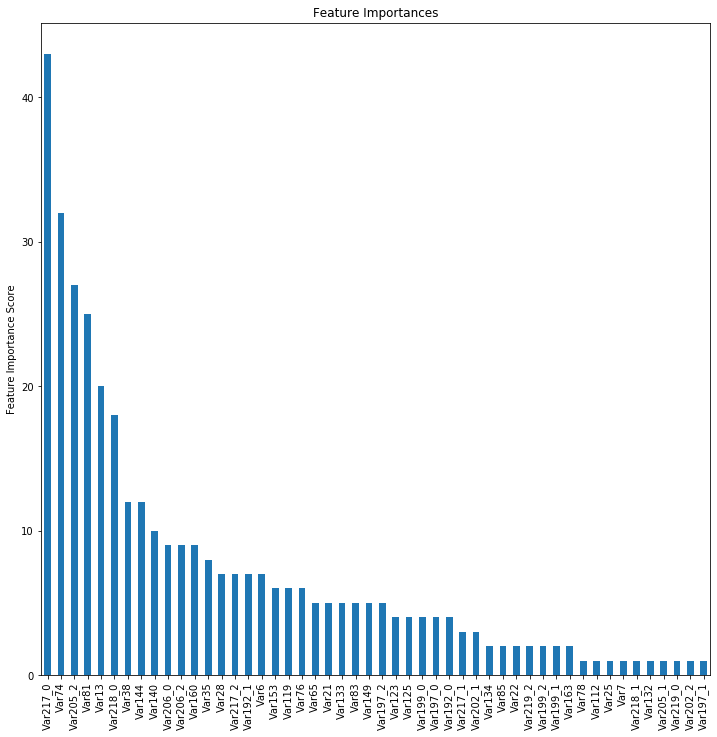

In [39]:
#Choose the predictors for xgboost and fit the model
modelfit(xgb2, X_train, predictors)

In [41]:
# Train roc_auc & Log Loss
y_predS_xgb2 = xgb2.predict_proba(X_train)
print('Validation AUC: ' + str( roc_auc_score(Y_train, y_predS_xgb2[:,1]) ))
print('Validation LogLoss: ' + str( log_loss(Y_train, y_predS_xgb2[:,1]) ))
metric_2 = log_loss(Y_train, y_predS[:,1])

Validation AUC: 0.6689294011259412
Validation LogLoss: 0.24726794648863143


In [106]:
# Save the model# Model with prcnt_common feature
joblib.dump(xgb2, model_path+model2)

['/Users/palashgoyal1/Downloads/CV/Case_Studies/Sigmoid/model/1/xgb2_cc_auc.pkl']

## Decile Info - Train a) Initial Model

In [42]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [43]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,3200,665.0,2535.0,0.285899,0.207813,0.085428,0.285899,0.085428,0.296069,2.858985
1,3200,338.0,2862.0,0.145314,0.105625,0.096448,0.431212,0.181876,0.296069,2.156062
2,3200,324.0,2876.0,0.139295,0.101250,0.096920,0.570507,0.278796,0.296069,1.901691
3,3200,242.0,2958.0,0.104041,0.075625,0.099683,0.674549,0.378479,0.296069,1.686371
4,3200,217.0,2983.0,0.093293,0.067812,0.100526,0.767842,0.479005,0.296069,1.535684
5,3200,178.0,3022.0,0.076526,0.055625,0.101840,0.844368,0.580845,0.296069,1.407280
6,3200,146.0,3054.0,0.062769,0.045625,0.102918,0.907137,0.683764,0.296069,1.295910
7,3200,107.0,3093.0,0.046002,0.033438,0.104233,0.953138,0.787996,0.296069,1.191423
8,3200,74.0,3126.0,0.031814,0.023125,0.105345,0.984953,0.893341,0.296069,1.094392
9,3200,35.0,3165.0,0.015047,0.010937,0.106659,1.000000,1.000000,0.296069,1.000000


Probability from classifier for Train
Response 10%: 0.2078125
Capture at 10%: 0.2858985382631126
Response 5%: 0.271875
Capture at 5%: 0.18701633705932932


(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Lift chart'),
 Text(0, 0.5, 'Lift'))

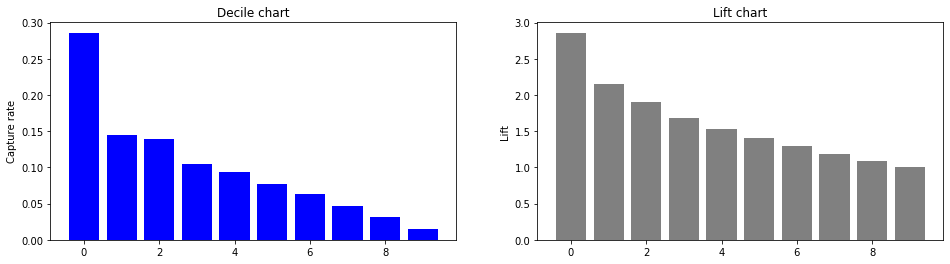

In [44]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print('Probability from classifier for Train' )
print('Response 10%: ' + str(dec_1_rr))
print('Capture at 10%: ' + str(dec_1_cr))
print('Response 5%: ' + str(per5_1_rr))
print('Capture at 5%: ' + str(per5_1_cr))

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

## Decile Info - Train b) Best Model out of GridSearch  : xgb2

In [45]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS_xgb2[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [46]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,3200,586.0,2614.0,0.251935,0.183125,0.088091,0.251935,0.088091,0.241362,2.519347
1,3200,327.0,2873.0,0.140585,0.102188,0.096819,0.392519,0.184909,0.241362,1.962597
2,3200,296.0,2904.0,0.127257,0.092500,0.097863,0.519776,0.282773,0.241362,1.732588
3,3200,242.0,2958.0,0.104041,0.075625,0.099683,0.623818,0.382456,0.241362,1.559544
4,3200,197.0,3003.0,0.084695,0.061562,0.101200,0.708512,0.483656,0.241362,1.417025
5,3200,192.0,3008.0,0.082545,0.060000,0.101368,0.791058,0.585024,0.241362,1.318429
6,3200,158.0,3042.0,0.067928,0.049375,0.102514,0.858985,0.687538,0.241362,1.227122
7,3200,140.0,3060.0,0.060189,0.043750,0.103121,0.919175,0.790658,0.241362,1.148968
8,3200,119.0,3081.0,0.051161,0.037187,0.103828,0.970335,0.894487,0.241362,1.078150
9,3200,69.0,3131.0,0.029665,0.021562,0.105513,1.000000,1.000000,0.241362,1.000000


Probability from classifier for Train
Response 10%: 0.183125
Capture at 10%: 0.2519346517626827
Response 5%: 0.221875
Capture at 5%: 0.15262252794496992


(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Lift chart'),
 Text(0, 0.5, 'Lift'))

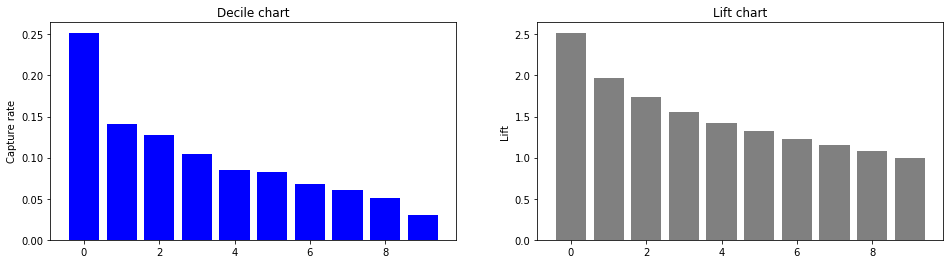

In [47]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print('Probability from classifier for Train' )
print('Response 10%: ' + str(dec_1_rr))
print('Capture at 10%: ' + str(dec_1_cr))
print('Response 5%: ' + str(per5_1_rr))
print('Capture at 5%: ' + str(per5_1_cr))

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

### Winning Model : 
Looks like the clear winner is the INITIAL Model, on the basis of the lift provided in the top Deciles

In [48]:
print("Model 1 metric value ",metric_1)
print("Model 2 metric value ",metric_2)

Model 1 metric value  0.24095932959954372
Model 2 metric value  0.24095932959954372


In [49]:
final_model = xgb1
final_grid = grid_1

## Decile Info - Validation

In [50]:
# Validation AUC
val_pred_xgb1 = final_model.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred_xgb1[:,1])))
print('Validation Log Loss: ' + str(log_loss(Y_val, val_pred_xgb1[:,1])))

Validation AUC: 0.6289229016949154
Validation Log Loss: 0.26509480861166956


In [51]:
# Decile related info
df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(val_pred_xgb1[:,1]) 
prob.columns = ['Probability']
prob["Target"] = Y_val.values 
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [52]:
# Decile info dataframe
df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,800,135.0,665.0,0.2160,0.16875,0.090169,0.2160,0.090169,0.177031,2.160000
1,800,82.0,718.0,0.1312,0.10250,0.097356,0.3472,0.187525,0.177031,1.736000
2,800,69.0,731.0,0.1104,0.08625,0.099119,0.4576,0.286644,0.177031,1.525333
3,800,66.0,734.0,0.1056,0.08250,0.099525,0.5632,0.386169,0.177031,1.408000
4,800,62.0,738.0,0.0992,0.07750,0.100068,0.6624,0.486237,0.177031,1.324800
5,800,57.0,743.0,0.0912,0.07125,0.100746,0.7536,0.586983,0.177031,1.256000
6,800,43.0,757.0,0.0688,0.05375,0.102644,0.8224,0.689627,0.177031,1.174857
7,800,42.0,758.0,0.0672,0.05250,0.102780,0.8896,0.792407,0.177031,1.112000
8,800,32.0,768.0,0.0512,0.04000,0.104136,0.9408,0.896542,0.177031,1.045333
9,800,37.0,763.0,0.0592,0.04625,0.103458,1.0000,1.000000,0.177031,1.000000


Probability from classifier for Validation
Response 10%: 0.16875
Capture at 10%: 0.216
Response 5%: 0.225
Capture at 5%: 0.144


(<BarContainer object of 10 artists>,
 Text(0.5, 1.0, 'Lift chart'),
 Text(0, 0.5, 'Lift'))

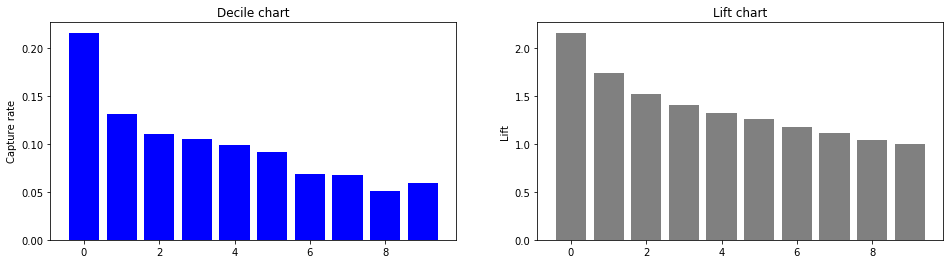

In [53]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print('Probability from classifier for Validation')
print('Response 10%: ' + str(dec_1_rr))
print('Capture at 10%: ' + str(dec_1_cr))
print('Response 5%: ' + str(per5_1_rr))
print('Capture at 5%: ' + str(per5_1_cr))

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

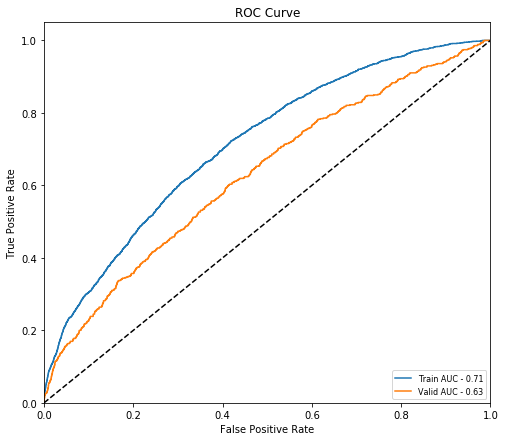

In [54]:
# Make ROC curve for train and validation as of now
fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred_xgb1[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)
# print roc_auc

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)   # Valid or Test ???
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

#### Feature Importance

In [56]:
feat_imp = pd.Series(final_model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [99]:
# Getting top 10 numerical features
print([x for x in feat_imp.features if '_' not in x][0:10])

['Var81', 'Var74', 'Var13', 'Var28', 'Var119', 'Var6', 'Var144', 'Var140', 'Var76', 'Var133']


In [102]:
# Getting top 10 features by importance
#print(list(feat_imp.features[0:10]))
print([x for x in feat_imp.features if '_' in x][0:10])

['Var217_0', 'Var205_2', 'Var218_0', 'Var192_0', 'Var192_1', 'Var197_0', 'Var202_0', 'Var202_1', 'Var199_1', 'Var197_1']


In [57]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,Var217_0,83.0,0.067866
1,Var81,76.0,0.062142
2,Var74,62.0,0.050695
3,Var205_2,58.0,0.047424
4,Var13,48.0,0.039248
5,Var28,48.0,0.039248
6,Var6,47.0,0.038430
7,Var218_0,40.0,0.032706
8,Var153,38.0,0.031071
9,Var144,37.0,0.030253


In [58]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

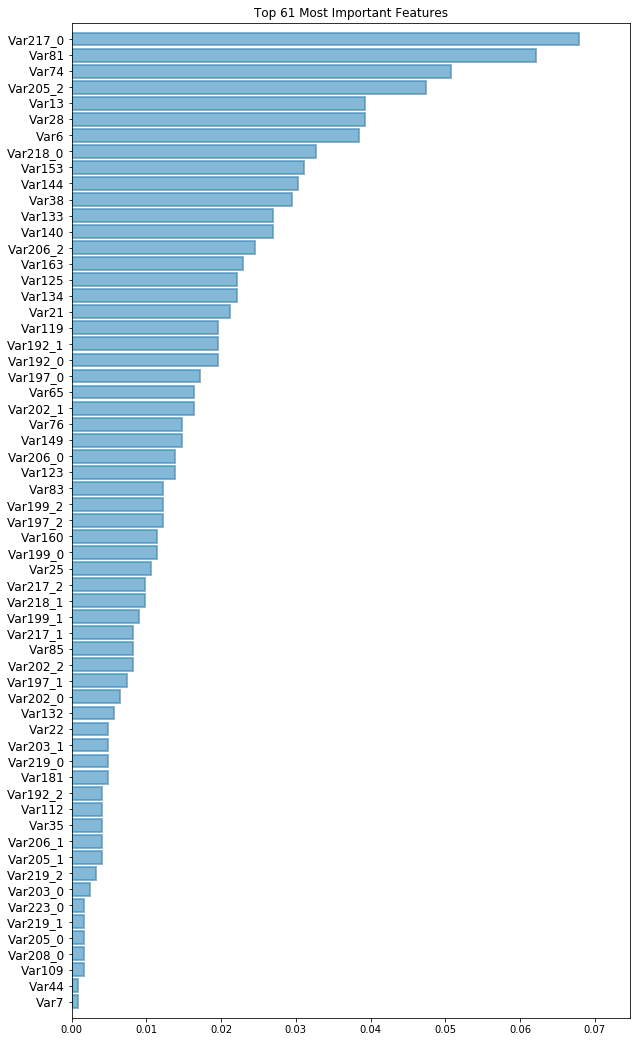

In [59]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

### Selecting the Best Model 'xgb1' from the above set of 2 Models (xgb1, xgb2) and training it on the full Train dataset

In [61]:
# xgboost fn
def modelfit2(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=val_tar[['labels']].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=[modelfit_metric], early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(val_tar),eval_metric=modelfit_metric)     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(val_tar), dtrain_predprob))
    print("LogLoss Score (Train): %f" % log_loss(np.ravel(val_tar), dtrain_predprob))
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(12,12))
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')    

/Users/palashgoyal1/Setups/anaconda3/envs/foodai/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


AUC Score (Train): 0.691487
LogLoss Score (Train): 0.246465


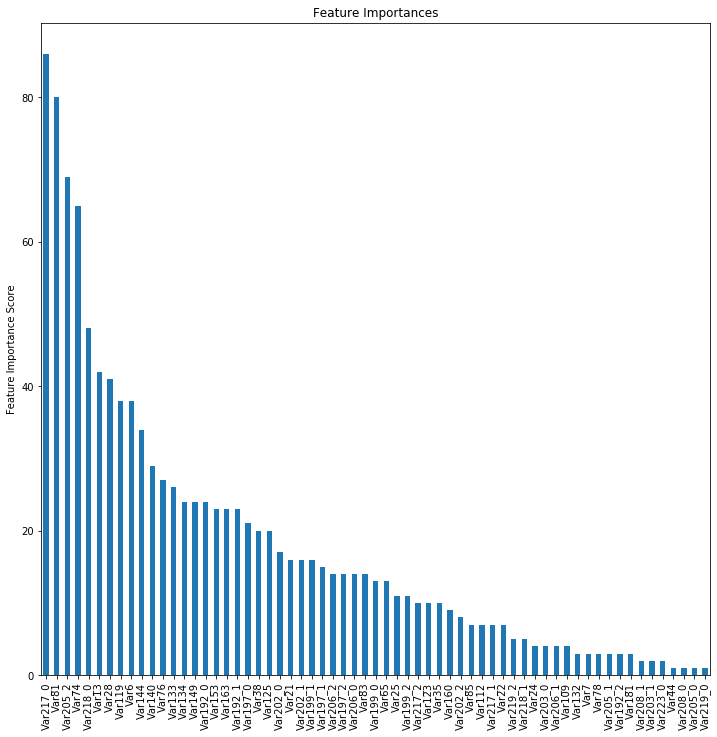

In [62]:
# Using the initially defined model on the initial given full training dataset
xgb3 = XGBClassifier(**final_grid)
modelfit2(xgb3, train_final, predictors)

In [63]:
# Train roc auc
y_predS_final = xgb3.predict_proba(train_final)
print('Validation AUC: ' + str(roc_auc_score(val_tar, y_predS_final[:,1]) ))
print('Validation Log Loss: ' + str(log_loss(val_tar, y_predS_final[:,1]) ))
metric_3  = log_loss(val_tar, y_predS_final[:,1]) 

Validation AUC: 0.6914873256358393
Validation Log Loss: 0.24646455341335385


In [64]:
# Selecting the FINAL MODEL as the one trained with INITIAL grid and trained on the Full Train dataset
joblib.dump(xgb3, model_path+model3)

['/Users/palashgoyal1/Downloads/CV/Case_Studies/Sigmoid/model/1/xgb3_cc_auc.pkl']

In [67]:
# Model with initial grid
# Cross validation AUC & LogLoss
cv_score_final = cross_val_score(xgb3, train_final, np.ravel(val_tar), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_final.mean()))
print('std auc: ' + str(cv_score_final.std()))
cv_score1_final = cross_val_score(xgb3, train_final, np.ravel(val_tar), cv = 5, scoring ='neg_log_loss')
print('mean log_loss: ' + str(cv_score1_final.mean()))
print('std log_loss: ' + str(cv_score1_final.std()))

mean auc: 0.6508975000760945
std auc: 0.006527054100610881
mean log_loss: -0.25216935939709656
std log_loss: 0.0009288072079337656


### Feature Importance (Model on Full Train Dataset)

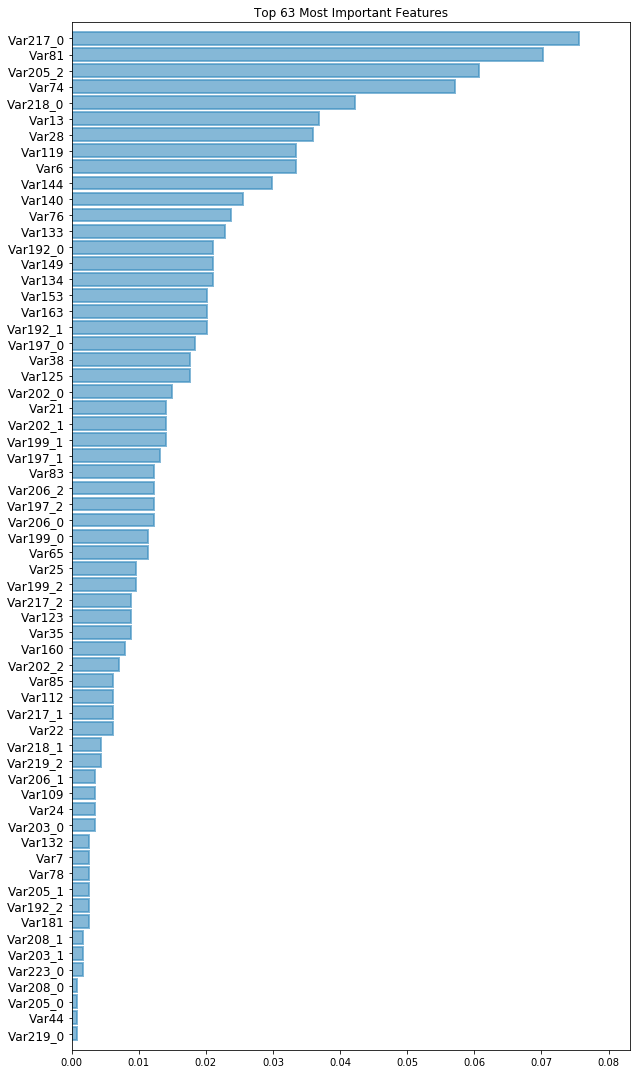

In [68]:
feat_imp = pd.Series(xgb3.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

### Storing the Predictions on Train Dataset on separate file, to find optimal threshold

In [72]:
# Picking the index
train_data_ind = pd.read_csv('../data/1/train_data.csv', usecols=[0])
train_data_ind.columns = ['rowindex']

train_rev = pd.read_csv(train_file, sep=',')
train_rev.index = train_data_ind.rowindex.values

In [105]:
cc_preds_app2 = pd.DataFrame({ 'label':list(val_tar['labels']), 'pred':y_predS_final[:,0]})
cc_preds_app2.index = train_data_ind.rowindex.values
cc_preds_app2.to_csv(home_path+train_pred_file_name)

In [106]:
cc_preds_app2.head()

,label,pred
23861,0,0.956904
14987,0,0.964891
2999,0,0.877918
13401,1,0.913261
19532,0,0.951395


## ROC - Lift - Calibration Plots

In [18]:
import warnings
warnings.filterwarnings("ignore")


In [23]:
#xgb3 = joblib.load(model_path+model3)

 AUC: 0.691487, lift at 10 percent: 2.660115


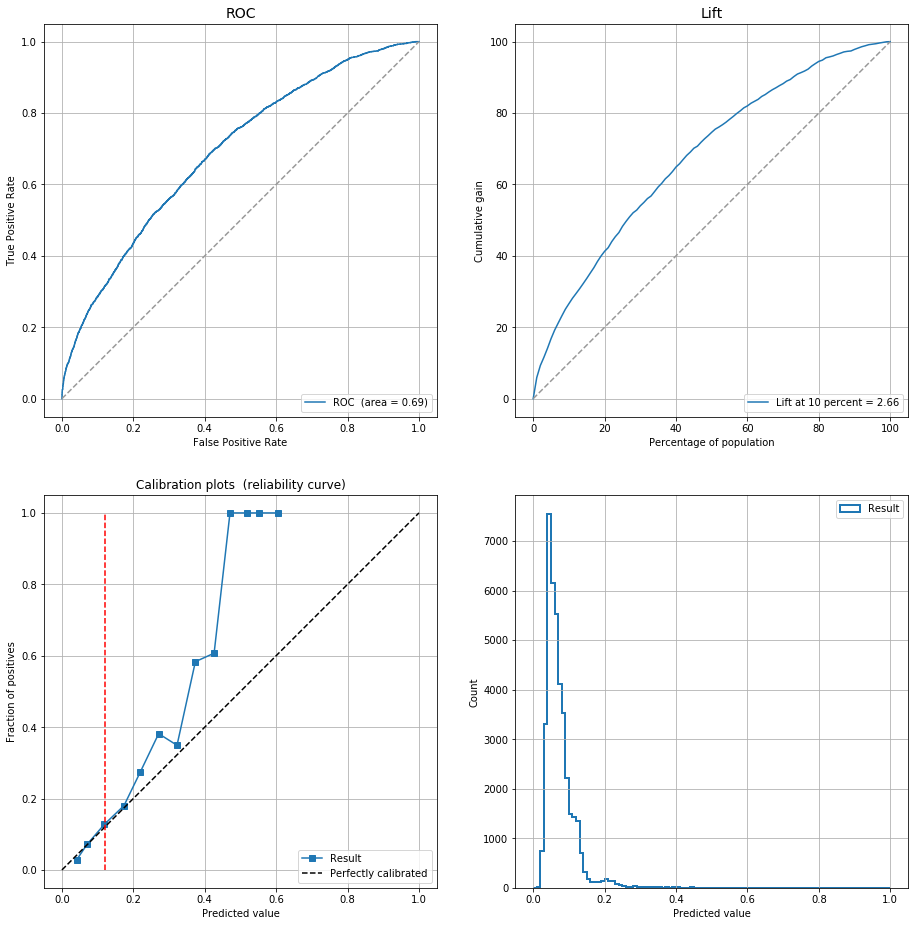

,Desired_Positive,Total_Contacts,Total_Population,Total_Positive,Positive_Rate,Prcnt_of_Positive_found,Prcnt_of_Population,Lift
0,100,197.0,40000,2951,0.507614,0.033887,0.004925,6.880572
1,200,495.0,40000,2951,0.404040,0.067774,0.012375,5.476657
2,500,2027.0,40000,2951,0.246670,0.169434,0.050675,3.343544
3,1000,6057.0,40000,2951,0.165098,0.338868,0.151425,2.237862
4,2000,17097.0,40000,2951,0.116980,0.677736,0.427425,1.585626
5,3000,NaN,40000,2951,NaN,1.016605,NaN,NaN
6,5000,NaN,40000,2951,NaN,1.694341,NaN,NaN
7,6000,NaN,40000,2951,NaN,2.033209,NaN,NaN
8,7000,NaN,40000,2951,NaN,2.372077,NaN,NaN
9,2951,39645.0,40000,2951,0.074436,1.000000,0.991125,1.008954


In [22]:
rlcfi.model_eval(xgb3, train_final, np.asarray(val_tar['labels']))